# Exploratory Data Analysis (EDA)

In this notebook, we will be performing EDA on the advanced features that we have created. For more information on the feature generation, please refer to this notebook.
<a href="https://adb-731998097721284.4.azuredatabricks.net/?o=731998097721284#notebook/632558266978843/command/632558266978844" target="_blank">Feature_engineering_Notebook</a>

**Note**: Since we would like to remain blind to the test data, we will perform our EDA on the training data post feature engineering.

#Loading all packages and datasets

In [0]:
from pyspark.sql.functions import col,isnan,when,count
from pyspark.sql import functions as f
from pyspark.sql import SQLContext
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql.functions import isnan, when, count, col, isnull, percent_rank, avg
from pyspark.sql.functions import min
from pyspark.sql.functions import col, max
from pyspark.sql.functions import format_string
from pyspark.sql.functions import substring
from pyspark.sql.functions import concat_ws
from pyspark.sql.functions import concat
from pyspark.sql.functions import to_timestamp
from pyspark.sql.functions import lit
from pyspark.sql.functions import to_utc_timestamp
from pyspark.sql.functions import expr
from pyspark.sql.functions import regexp_replace
from pyspark.sql.functions import instr
from pyspark.sql.functions import row_number
from pyspark.sql.window import Window
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.mllib.util import MLUtils
from pyspark.mllib.regression import LabeledPoint
from pyspark.ml.linalg import Vectors
from pyspark.mllib.evaluation import MulticlassMetrics
import random as rnd
from pyspark.sql.functions import mean as _mean

from pyspark.sql.types import IntegerType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
# ignoring this for now. 
#Initializes blob storage credentials/location
blob_container = "w261-sec4-group2" # The name of your container created in https://portal.azure.com
storage_account = "kdevery" # The name of your Storage account created in https://portal.azure.com
secret_scope = "sec4-group2" # The name of the scope created in your local computer using the Databricks CLI
secret_key = "w261-key" # The name of the secret key created in your local computer using the Databricks CLI 
blob_url = f"wasbs://{blob_container}@{storage_account}.blob.core.windows.net"
mount_path = "/mnt/mids-w261"

#Points to SAS token
spark.conf.set(
  f"fs.azure.sas.{blob_container}.{storage_account}.blob.core.windows.net",
  dbutils.secrets.get(scope = secret_scope, key = secret_key)
)

# Advanced Feature Engineering EDA

In [0]:
# displaying dataset in our storage blob
display(dbutils.fs.ls(f"wasbs://{blob_container}@{storage_account}.blob.core.windows.net"))

path,name,size,modificationTime
wasbs://w261-sec4-group2@kdevery.blob.core.windows.net/MLPC_predictions_df/,MLPC_predictions_df/,0,1670111625000
wasbs://w261-sec4-group2@kdevery.blob.core.windows.net/feature_engineered_data/,feature_engineered_data/,0,1668924639000
wasbs://w261-sec4-group2@kdevery.blob.core.windows.net/feature_engineered_data_test/,feature_engineered_data_test/,0,1668924670000
wasbs://w261-sec4-group2@kdevery.blob.core.windows.net/feature_engineered_train_data/,feature_engineered_train_data/,0,1668559613000
wasbs://w261-sec4-group2@kdevery.blob.core.windows.net/merged_cleaned_data/,merged_cleaned_data/,0,1669494945000
wasbs://w261-sec4-group2@kdevery.blob.core.windows.net/merged_cleaned_data_test/,merged_cleaned_data_test/,0,1669495012000
wasbs://w261-sec4-group2@kdevery.blob.core.windows.net/merged_cleaned_data_train/,merged_cleaned_data_train/,0,1669495000000
wasbs://w261-sec4-group2@kdevery.blob.core.windows.net/merged_data/,merged_data/,0,1669494746000
wasbs://w261-sec4-group2@kdevery.blob.core.windows.net/number_flights_and_delay_rate/,number_flights_and_delay_rate/,0,1669961275000
wasbs://w261-sec4-group2@kdevery.blob.core.windows.net/pagerank_scores/,pagerank_scores/,0,1669963319000


In [0]:
train_df = spark.read.parquet(f"wasbs://{blob_container}@{storage_account}.blob.core.windows.net/train_data_with_adv_features")
test_df = spark.read.parquet(f"wasbs://{blob_container}@{storage_account}.blob.core.windows.net/test_data_with_adv_features")

print(f' Training Data: number of rows = {train_df.count()}, number of columns =  {len(train_df.columns)}')

print(f' Training Data: number of rows = {test_df.count()}, number of columns =  {len(test_df.columns)}')

 Training Data: number of rows = 35366654, number of columns =  61
 Training Data: number of rows = 5859306, number of columns =  61


***Dataset Sizes:*** 

• Train Data: 35366654 rows (contains data from 2015-2020)

• Test Data: 5859306 rows (contains data from 2021)

In [0]:
display(train_df)

DEP_DEL15,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,two_hrs_pre_flight_utc,Date_Time_sched_dep_utc,Date_Time_sched_arrival_utc,OP_CARRIER,TAIL_NUM,ORIGIN,DEST,CRS_DEP_TIME,CRS_ARR_TIME,ARR_DELAY,CRS_ELAPSED_TIME,DISTANCE,DISTANCE_GROUP,ELEVATION,HourlyAltimeterSetting,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyPrecipitation,HourlyRelativeHumidity,HourlySeaLevelPressure,HourlyStationPressure,HourlyVisibility,HourlyWetBulbTemperature,HourlyWindDirection,HourlyWindSpeed,HourlyWindGustSpeed,Route,Rain,Snow,Thunder,Fog,Mist,Freezing,Blowing,Smoke,Drizzle,Overcast,Broken,Scattered,CloudySkyCondition,holiday_period,mean_carrier_delay,Pagerank_Score,PREV_FLIGHT_DELAYED,origin_flight_per_day,origin_delays_per_day,dest_flight_per_day,dest_delays_per_day,origin_percent_delayed,dest_percent_delayed,ORIGIN_Prophet_trend,ORIGIN_Prophet_pred,DEST_Prophet_trend,DEST_Prophet_pred
1.0,2015,1,3,16,1,2015-03-16,2015-03-16T16:00:00.000+0000,2015-03-16T18:00:00.000+0000,2015-03-16T20:00:00.000+0000,EV,N16987,ORD,ABE,1326,1618,39,112.0,654.0,3,201.8,29.91,36,60,0.0,41,29.91,29.19,10.0,48,230,7,0,ORD_ABE,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0.12020033388981637,0.01628308991187966,1,699,128.0,3,0.0,0.18311874105865522,0.0,0.2607316376980994,0.19148477084001575,0.13692763770669927,0.08499737548696276
0.0,2015,1,3,16,1,2015-03-16,2015-03-17T00:00:00.000+0000,2015-03-17T02:00:00.000+0000,2015-03-17T03:00:00.000+0000,EV,N17159,ORD,ABE,2100,2353,-12,113.0,654.0,3,201.8,29.77,47,68,0.0,47,29.76,29.05,10.0,57,250,11,0,ORD_ABE,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0.09429824561403509,0.01628308991187966,0,699,128.0,3,0.0,0.18311874105865522,0.0,0.2607316376980994,0.19148477084001575,0.13692763770669927,0.08499737548696276
0.0,2015,1,3,16,1,2015-03-16,2015-03-16T15:00:00.000+0000,2015-03-16T17:00:00.000+0000,2015-03-16T19:00:00.000+0000,OO,N8968E,DTW,ABE,1355,1521,-5,86.0,425.0,2,192.3,29.92,37,57,0.0,47,29.92,29.21,10.0,47,250,8,0,DTW_ABE,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0.1235820895522388,0.011267497060799408,0,238,19.0,3,0.0,0.07983193277310924,0.0,0.1777465882992688,0.13785970537200365,0.13692763770669927,0.08499737548696276
0.0,2015,1,3,16,1,2015-03-16,2015-03-16T22:00:00.000+0000,2015-03-17T00:00:00.000+0000,2015-03-17T01:00:00.000+0000,EV,N981EV,DTW,ABE,2026,2150,-19,84.0,425.0,2,192.3,29.8,45,58,0.0,62,29.8,29.09,10.0,51,160,8,0,DTW_ABE,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0.10290093048713739,0.011267497060799408,0,238,19.0,3,0.0,0.07983193277310924,0.0,0.1777465882992688,0.13785970537200365,0.13692763770669927,0.08499737548696276
0.0,2015,1,3,16,1,2015-03-16,2015-03-16T12:00:00.000+0000,2015-03-16T14:00:00.000+0000,2015-03-16T15:00:00.000+0000,EV,N926EV,DTW,ABE,1005,1130,-4,85.0,425.0,2,192.3,29.92,37,46,0.0,71,29.92,29.21,10.0,42,220,7,0,DTW_ABE,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0.11534154535274356,0.011267497060799408,0,238,19.0,3,0.0,0.07983193277310924,0.0,0.1777465882992688,0.13785970537200365,0.13692763770669927,0.08499737548696276
0.0,2015,1,3,16,1,2015-03-16,2015-03-16T12:00:00.000+0000,2015-03-16T14:00:00.000+0000,2015-03-16T16:00:00.000+0000,EV,N837AS,ATL,ABE,1026,1222,13,116.0,692.0,3,307.8,30.2,40,51,0.0,66,30.19,29.1,10.0,46,300,7,0,ATL_ABE,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.11534154535274356,0.0405444716972231,0,920,170.0,3,0.0,0.18478260869565216,0.0,0.17059499897245625,0.11274663968179394,0.13692763770669927,0.08499737548696276
0.0,2015,1,3,16,1,2015-03-16,2015-03-16T22:00:00.000+0000,2015-03-17T00:00:00.000+0000,2015-03-17T02:00:00.000+0000,DL,N919AT,ATL,ABE,2046,2243,4,117.0,692.0,3,307.8,30.06,24,80,0.0,13,30.05,28.96,10.0,54,240,5,0,ATL_ABE,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0.10464646464646464,0.0405444716972231,0,920,170.0,3,0.0,0.18478260869565216,0.0,0.17059499897245625,0.11274663968179394,0.13692763770669927,0.08499737548696276
0.0,2015,1,3,16,1,2015-03-16,2015-03-16T16:00:00.000+0000,2015-03-16T18:00:00.000+0000,2015-03-16T20:00:00.000+0000,EV,N878AS,ATL,ABE,1457,1653,14,116.0,692.0,3,307.8,30.19,31,76,0.0,19,30.17,29.09,10.0,54,340,6,0,ATL_ABE,0,0,0,0

### Null Values Analysis

Here we look at missing values in our train data to see if there are any features that we would have to come up with a imputation strategy for.

In [0]:
#MISSING VALUES
 
missing_counts = train_df.select([count(when(col(c).isNull(), c)).alias(c) for c in train_df.columns]).toPandas()
 
display(missing_counts)

DEP_DEL15,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,two_hrs_pre_flight_utc,Date_Time_sched_dep_utc,Date_Time_sched_arrival_utc,OP_CARRIER,TAIL_NUM,ORIGIN,DEST,CRS_DEP_TIME,CRS_ARR_TIME,ARR_DELAY,CRS_ELAPSED_TIME,DISTANCE,DISTANCE_GROUP,ELEVATION,HourlyAltimeterSetting,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyPrecipitation,HourlyRelativeHumidity,HourlySeaLevelPressure,HourlyStationPressure,HourlyVisibility,HourlyWetBulbTemperature,HourlyWindDirection,HourlyWindSpeed,HourlyWindGustSpeed,Route,Rain,Snow,Thunder,Fog,Mist,Freezing,Blowing,Smoke,Drizzle,Overcast,Broken,Scattered,CloudySkyCondition,holiday_period,mean_carrier_delay,Pagerank_Score,PREV_FLIGHT_DELAYED,origin_flight_per_day,origin_delays_per_day,dest_flight_per_day,dest_delays_per_day,origin_percent_delayed,dest_percent_delayed,ORIGIN_Prophet_trend,ORIGIN_Prophet_pred,DEST_Prophet_trend,DEST_Prophet_pred
0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,87723,8,0,0,40298,49386,69420,59450,2671665,59362,303541,198427,83106,210109,1732043,69668,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,134,0,2,50681,50681,49223,49223,50681,49223,1201,1201,3324,3324


Out[10]: <AxesSubplot:title={'center':'Missing Values'}, xlabel='Features', ylabel='Counts'>

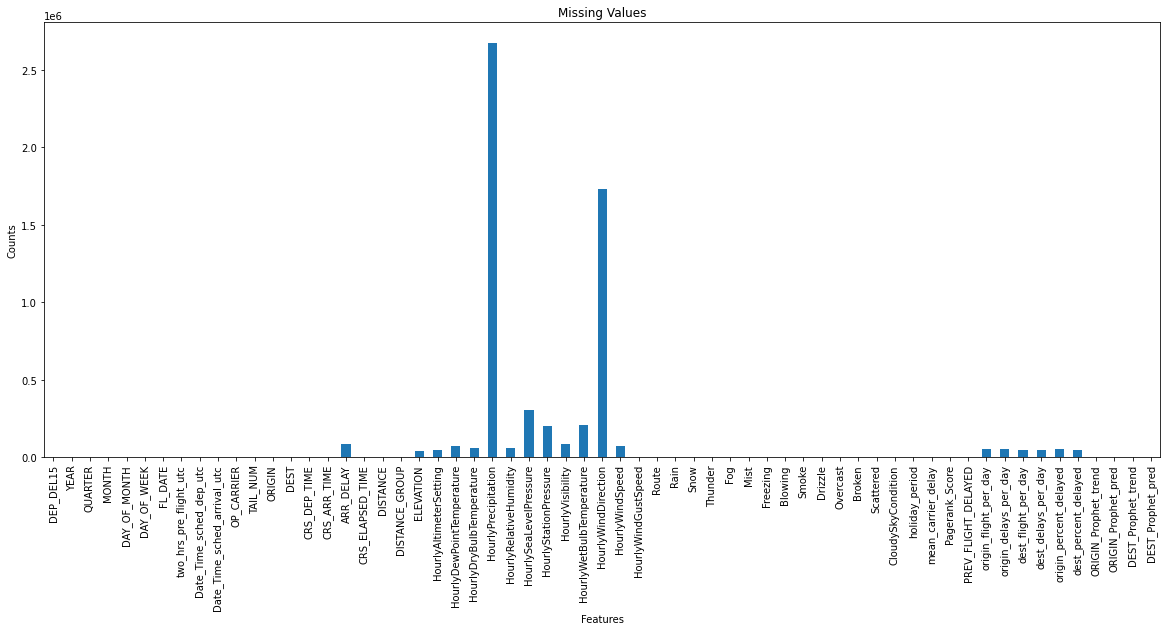

In [0]:
null_count = missing_counts.transpose()
null_count.plot(kind = 'bar',figsize = (20,8), title = 'Missing Values',
                legend = False, xlabel = 'Features', ylabel = 'Counts',fontsize = 10)

From the plot above, we can see that some values are missing in our training dataset. If we decide to use these variables going forward, we will need to come up with some type of imputation strategy.

### Correlation Analysis

In this section, we will perform a correlations analysis, to see if any features that we think are interesting are correlated with our variable of interest (DEP_DEL_15), which describes whether or not a flight was delayed.

Out[11]: <AxesSubplot:title={'center':'Pearson Correlation Heatmap'}>

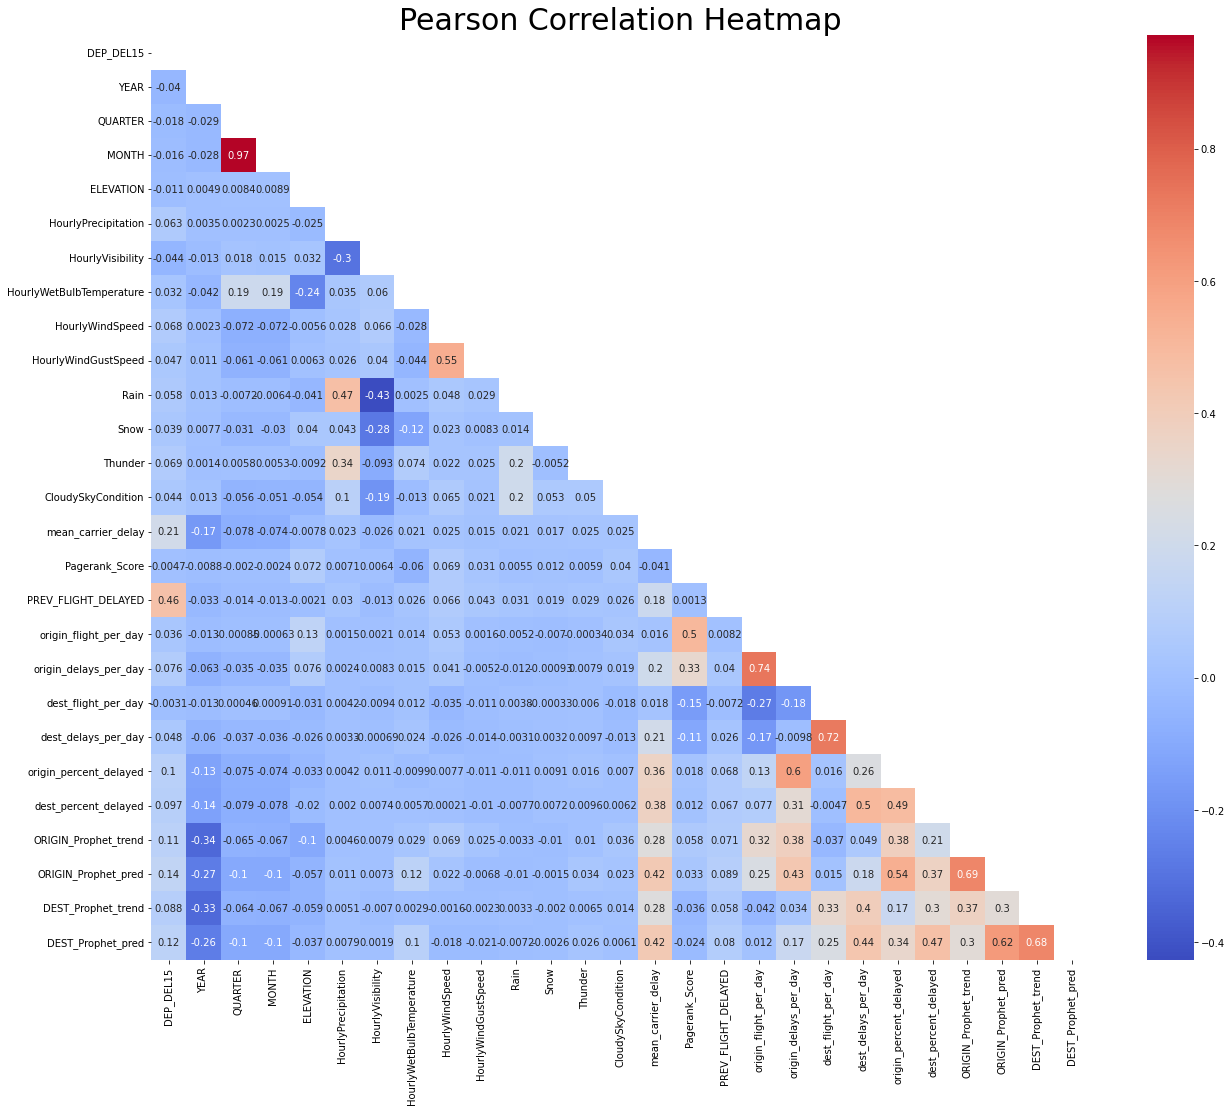

In [0]:
interesting_columns = ['DEP_DEL15','YEAR','QUARTER','MONTH','ELEVATION','HourlyPrecipitation','HourlyVisibility','HourlyWetBulbTemperature','HourlyWindSpeed',
 'HourlyWindGustSpeed','Rain','Snow','Thunder','CloudySkyCondition','mean_carrier_delay','Pagerank_Score',
                      'PREV_FLIGHT_DELAYED','origin_flight_per_day','origin_delays_per_day','dest_flight_per_day','dest_delays_per_day',
                      'origin_percent_delayed','dest_percent_delayed','ORIGIN_Prophet_trend','ORIGIN_Prophet_pred',
                      'DEST_Prophet_trend','DEST_Prophet_pred']

# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=interesting_columns, outputCol=vector_col)
df_vector = assembler.setHandleInvalid('skip').transform(train_df).select(vector_col)
 
# get correlation matrix
matrix = Correlation.corr(df_vector, vector_col).collect()[0][0]
correlation_matrix = matrix.toArray().tolist()

corr_matrix_df = pd.DataFrame(data=correlation_matrix)
mask = np.triu(np.ones_like(corr_matrix_df, dtype=bool))
plt.figure(figsize=(21,17))
plt.title('Pearson Correlation Heatmap',size=30)
sns.heatmap(corr_matrix_df, 
            xticklabels=interesting_columns,
            yticklabels=interesting_columns,  cmap="coolwarm", annot=True, mask=mask)
 

From the heatmap above, we can see that previous flight delayed feature is strongly correlated with the outcome variable. Mean_carrier_Delay has the second strongest correlation with the outcome variable.

### Exploration of Delays by Route
Below, we take a look at which routes are the most popular and what the fraction of delayed flights are for those routes.

In [0]:
display(train_df.groupBy('Route').count().orderBy(col('count').desc()).take(20))

Route,count
SFO_LAX,84171
LAX_SFO,83245
JFK_LAX,69185
LAX_JFK,69175
LGA_ORD,64242
ORD_LGA,64068
LAS_LAX,63094
LAX_LAS,63080
OGG_HNL,54490
HNL_OGG,54438


Output can only be rendered in Databricks

In [0]:
#Flight delay by airport route
airport_route_delay_count_0 = train_df.groupby('Route', 'DEP_DEL15').count().filter(train_df.DEP_DEL15 != "1")
airport_route_delay_count_1 = train_df.groupby('Route', 'DEP_DEL15').count().filter(train_df.DEP_DEL15 != "0")
airport_route_delay_count_1 = airport_route_delay_count_1.selectExpr("Route as Route_1", "DEP_DEL15 as DEP_DEL15_1", "count as count_1")
airport_route_delay_count_0 = airport_route_delay_count_0.join(airport_route_delay_count_1,airport_route_delay_count_0.Route ==  airport_route_delay_count_1.Route_1,"inner")
airport_route_delay_count_0 = airport_route_delay_count_0.drop(airport_route_delay_count_0.Route_1)
airport_route_delay_count_0 = airport_route_delay_count_0.withColumn("total", col("count")+col("count_1"))
airport_route_delay_count_0 = airport_route_delay_count_0.withColumn("relative_delay", (col("count_1") / (col("count")+col("count_1"))) * 100).orderBy(col('relative_delay').desc()).take(20)
display(airport_route_delay_count_0)

Route,DEP_DEL15,count,DEP_DEL15_1,count_1,total,relative_delay
TWF_ORD,0.0,1,1.0,6,7,85.71428571428571
OAK_FLL,0.0,2,1.0,8,10,80.0
FAR_JMS,0.0,1,1.0,3,4,75.0
TWF_SEA,0.0,2,1.0,5,7,71.42857142857143
TTN_CVG,0.0,1,1.0,2,3,66.66666666666666
MSY_GSP,0.0,1,1.0,2,3,66.66666666666666
SAN_ORF,0.0,3,1.0,6,9,66.66666666666666
UST_IAD,0.0,1,1.0,2,3,66.66666666666666
RDU_VPS,0.0,8,1.0,15,23,65.21739130434783
TWF_SFO,0.0,32,1.0,60,92,65.21739130434783


Output can only be rendered in Databricks

In [0]:
# let's investigate the number of delays in the top of 20 route by volume. 
airport_route_delay_count_0 = train_df.groupby('Route', 'DEP_DEL15').count().filter(train_df.DEP_DEL15 != "1")
airport_route_delay_count_1 = train_df.groupby('Route', 'DEP_DEL15').count().filter(train_df.DEP_DEL15 != "0")
airport_route_delay_count_1 = airport_route_delay_count_1.selectExpr("Route as Route_1", "DEP_DEL15 as DEP_DEL15_1", "count as count_1")
airport_route_delay_count_0 = airport_route_delay_count_0.join(airport_route_delay_count_1,airport_route_delay_count_0.Route ==  airport_route_delay_count_1.Route_1,"inner")
airport_route_delay_count_0 = airport_route_delay_count_0.drop(airport_route_delay_count_0.Route_1)
airport_route_delay_count_0 = airport_route_delay_count_0.withColumn("total", col("count")+col("count_1"))
airport_route_delay_count_00 = airport_route_delay_count_0.withColumn("relative_delay", col("count_1") / (col("count")+col("count_1"))).orderBy(col('total').desc()).take(20)
display(airport_route_delay_count_00)

Route,DEP_DEL15,count,DEP_DEL15_1,count_1,total,relative_delay
SFO_LAX,0.0,66741,1.0,17430,84171,0.2070784474462701
LAX_SFO,0.0,62400,1.0,20845,83245,0.25040542975554086
JFK_LAX,0.0,58517,1.0,10668,69185,0.15419527354195273
LAX_JFK,0.0,55426,1.0,13749,69175,0.19875677629201302
LGA_ORD,0.0,51673,1.0,12569,64242,0.195650820335606
ORD_LGA,0.0,48297,1.0,15771,64068,0.24616032964974716
LAS_LAX,0.0,51209,1.0,11885,63094,0.1883697340476115
LAX_LAS,0.0,50633,1.0,12447,63080,0.19732086239695626
OGG_HNL,0.0,50590,1.0,3900,54490,0.07157276564507249
HNL_OGG,0.0,51556,1.0,2882,54438,0.052940960358573055


Output can only be rendered in Databricks

### Potentially Redundant Variables
Finally, we look at some weather-related variables that we did not look at in the the previous heatmap, to see if these variables are highly correlated and would thus be redundant.

In [0]:
final_df_numerical = train_df.withColumn("ELEVATION", train_df["ELEVATION"].cast(IntegerType())) \
                             .withColumn("HourlyAltimeterSetting", train_df["HourlyAltimeterSetting"].cast(IntegerType())) \
                             .withColumn("HourlyDewPointTemperature", train_df["HourlyDewPointTemperature"].cast(IntegerType())) \
                             .withColumn("HourlyDryBulbTemperature", train_df["HourlyDryBulbTemperature"].cast(IntegerType())) \
                             .withColumn("HourlyPrecipitation", train_df["HourlyPrecipitation"].cast(IntegerType())) \
                             .withColumn("HourlyRelativeHumidity", train_df["HourlyRelativeHumidity"].cast(IntegerType())) \
                             .withColumn("HourlySeaLevelPressure", train_df["HourlySeaLevelPressure"].cast(IntegerType())) \
                             .withColumn("HourlyStationPressure", train_df["HourlyStationPressure"].cast(IntegerType())) \
                             .withColumn("HourlyVisibility", train_df["HourlyVisibility"].cast(IntegerType())) \
                             .withColumn("HourlyWetBulbTemperature", train_df["HourlyWetBulbTemperature"].cast(IntegerType())) \
                             .withColumn("HourlyWindGustSpeed", train_df["HourlyWindGustSpeed"].cast(IntegerType())) \
                             .withColumn("HourlyWindSpeed", train_df["HourlyWindSpeed"].cast(IntegerType())) \
                             .withColumn("CRS_ELAPSED_TIME", train_df["CRS_ELAPSED_TIME"].cast(IntegerType())) \
                             .withColumn("DISTANCE", train_df["DISTANCE"].cast(IntegerType()))
 
final_df_numerical_columns = final_df_numerical.select('ELEVATION','DISTANCE','HourlyAltimeterSetting','HourlyDewPointTemperature','HourlyDryBulbTemperature',
                       'HourlyPrecipitation','HourlyRelativeHumidity','HourlySeaLevelPressure','HourlyStationPressure','HourlyVisibility','HourlyWetBulbTemperature',
                       'HourlyWindDirection','HourlyWindSpeed','HourlyWindGustSpeed')
 
correlation_columns = ['ELEVATION','DISTANCE','HourlyAltimeterSetting','HourlyDewPointTemperature','HourlyDryBulbTemperature',
                       'HourlyPrecipitation','HourlyRelativeHumidity','HourlySeaLevelPressure','HourlyStationPressure','HourlyVisibility','HourlyWetBulbTemperature',
                       'HourlyWindDirection','HourlyWindSpeed','HourlyWindGustSpeed']
vector_column = "correlation_features"
assembler = VectorAssembler(inputCols=correlation_columns, outputCol=vector_column)
df_vector = assembler.setHandleInvalid('skip').transform(final_df_numerical_columns).select(vector_column)
# display(df_vector)
 
# correlation matrix
matrix = Correlation.corr(df_vector, vector_column).collect()[0][0]
correlation_matrix = matrix.toArray().tolist()

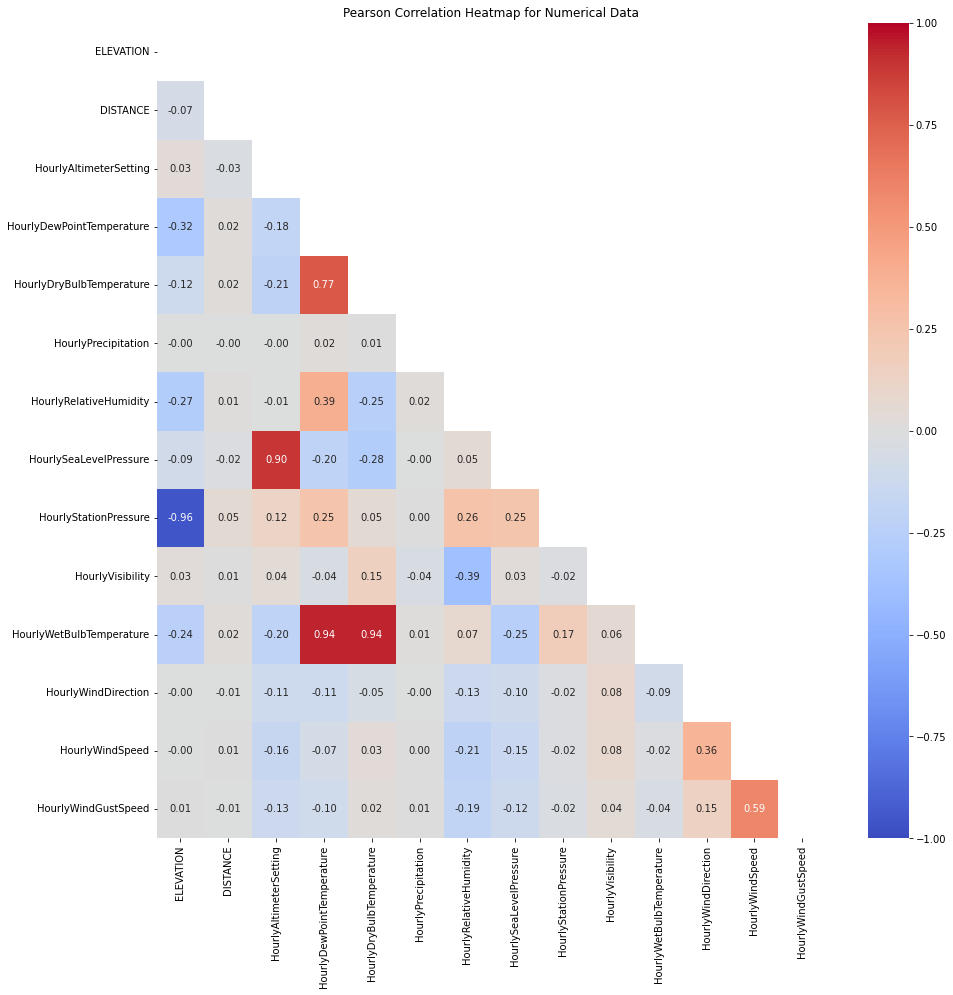

In [0]:
#plot heatmap
mask1 = np.triu(np.ones_like(correlation_matrix, dtype=bool))
fig,ax=plt.subplots(figsize=(15,15))
_=sns.heatmap(correlation_matrix,mask=mask1,annot=True,fmt='.2f',
              ax=ax,xticklabels=correlation_columns,
              yticklabels=correlation_columns,
             cmap ='coolwarm',vmin=-1,vmax=1)
_=ax.set_title('Pearson Correlation Heatmap for Numerical Data')
plt.show()

From the heatmap above, we see that some variables, such as "HourlyDewPointTemperature" and "HourlyDryBulbTemperature" are highly correlated, so therefore we do not need to include both in our models.

### Creating a map of airports and their closest weather stations

In [0]:
data_BASE_DIR = "dbfs:/mnt/mids-w261/datasets_final_project_2022/"
 
df_stations = spark.read.parquet(f"{data_BASE_DIR}stations_data/*")
 
df_airlines = spark.read.parquet(f"{data_BASE_DIR}parquet_airlines_data/")
# display(df_airlines)
 
df_weather = spark.read.parquet(f"{data_BASE_DIR}parquet_weather_data/")
#display(df_weather)

#import dataset
airport_codes_with_time_zones = pd.read_csv('https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat', header=None)
column_namess = {0: 'AirportID', 1: 'Name', 2: 'City', 3: 'Country', 4: 'IATA', 5: 'ICAO', 6: 'airport_latitude', 
             7: 'airport_longitude', 8: 'airport_elevation', 9: 'Timezone', 10: 'Daylight_savings_time', 11: 'TZ_Timezone', 12: 'Type', 13: 'Source'}
 
#add column names 
airport_codes_with_time_zones.rename(columns=column_namess, inplace=True)
#selecting desired columns 
codes = airport_codes_with_time_zones[['Country','IATA','ICAO','Timezone', 'TZ_Timezone']]
 
# found one airport in the final dataset wiht invalid timezone
# codes.loc[codes['IATA'] == 'BIH', 'TZ_Timezone'] = 'America/Los_Angeles' 
 
#converting to PySpark Dataframe
airport_codes = spark.createDataFrame(codes)
 
#filtering stations data set with airport_codes dataset
stations_data_filtered = df_stations.join(airport_codes).where(df_stations["neighbor_call"] == airport_codes["ICAO"])
 
#selecting US, Puerto Rico, and Virgin Islands.
countries =['United States','Puerto Rico','Virgin Islands']
stations_data_filtered_US = stations_data_filtered.filter(stations_data_filtered.Country.isin(countries))
 
#selecting desired columns
cols_to_keeep = ['neighbor_call','IATA','station_id',
                 'lon','lat', 'neighbor_lat', 'neighbor_lon','distance_to_neighbor']
 
stations_data_us = stations_data_filtered_US.select(cols_to_keeep)
 
minimum_distance = stations_data_us.groupby('neighbor_call').agg(min('distance_to_neighbor'))
f_airport_stations = stations_data_us.join(minimum_distance, ['neighbor_call'])
 
#final station data
station_final_usa = f_airport_stations.filter(f_airport_stations['distance_to_neighbor'] == f_airport_stations['min(distance_to_neighbor)'])
airportss = station_final_usa.dropDuplicates(['IATA'])
airports_pd = airportss.toPandas()
stationss = station_final_usa.dropDuplicates(['station_id'])
stations_pd = stationss.toPandas()

In [0]:
#creating the map

import plotly.graph_objects as plotly
 
fig = plotly.Figure(data=plotly.Scattergeo(
         lat = airports_pd['neighbor_lat'],
         lon = airports_pd['neighbor_lon'],
         text = airports_pd['IATA'],
         name = 'Airport',
         marker_symbol = 'x-dot',
         marker_color = 'green',
         opacity = 0.5))
fig.add_trace(plotly.Scattergeo(
         lat = stations_pd['lat'],
         lon = stations_pd['lon'],
         marker_color = 'red',
         name = 'Weather Stations',
         marker_symbol = 'circle-dot',
         marker_size = 2))
fig.update_layout(
         title = 'Airports & their Closest Weather Stations',
         geo_scope='usa',
         autosize=False,
         width=1000,
         height=600,)
fig.show()

From the graph above, we can see that even though we had included Puerto Rico and Virgin Island in our fitler, it does not show up in our map. Therefore, we would only focus on the US 50 states

Next, let's explore whether if there is a spike in delays during holiday periods.

In [0]:
display(train_df.groupBy('DEP_DEL15','holiday_period').count())

DEP_DEL15,holiday_period,count
1.0,1,69829
0.0,0,28944210
1.0,0,5964531
0.0,1,388084


Output can only be rendered in Databricks

As we can fromt the plot above, Holiday periods do not seem to have any major effects on the delay percentage.

Next, it would be interesting to if having a higher daily carrier delay average has any effects on the delays.

In [0]:
distinct_carrier_count = train_df.groupBy("OP_CARRIER").count()
distinct_carrier_mean_delay_agg = train_df.groupBy("OP_CARRIER",'DEP_DEL15').agg(f.sum("mean_carrier_delay"))
combined = distinct_carrier_mean_delay_agg.join(distinct_carrier_count, ["OP_CARRIER"])
combined_filter = combined.filter(f.col('DEP_DEL15') == '1')
aaa = combined_filter.withColumn('Percentage_daily_delayed_per_carrier',(col('sum(mean_carrier_delay)') / col('count')) * 100)
display(aaa)

OP_CARRIER,DEP_DEL15,sum(mean_carrier_delay),count,Percentage_daily_delayed_per_carrier
HA,1.0,3607.651688283566,437030,0.8254929154253863
WN,1.0,338470.3044059311,7347726,4.606463338534004
YX,1.0,21450.940227847037,837059,2.562655706210319
OH,1.0,29658.620985979604,728764,4.0697154340746255
EV,1.0,64522.96742457669,1741840,3.7042993285592645
G4,1.0,10914.164170377271,283427,3.850784918295459
YV,1.0,19140.418500733827,561262,3.410246640737094
US,1.0,4931.6915671372135,192615,2.560388114704054
MQ,1.0,39261.53419906345,1081241,3.6311547748433
B6,1.0,99681.10071381865,1439461,6.924890685737137


Output can only be rendered in Databricks

As we can from the graph above, some carrier are more likely to have delays than others.

We will now look at the PageRank Scores for the top 50 highest PageRank Scores per airport

In [0]:
display(train_df.groupBy('ORIGIN','Pagerank_Score').count().orderBy(col('Pagerank_Score').desc()).take(50))

ORIGIN,Pagerank_Score,count
OMA,0.07913310912151737,121465
MSP,0.07302706173832013,796857
LGA,0.06408282273375274,681791
ATL,0.0405444716972231,2136202
MYR,0.03461848515466535,47673
MCO,0.03184182528137983,713256
ALB,0.027226058199824658,57891
SFB,0.02473959530145402,27314
ATW,0.023480049689986272,20619
DEN,0.021111536800748086,1325530


Output can only be rendered in Databricks

Let's try to explore the origin percent delay for prior day and its relation to the current day delay

In [0]:
origin_count = train_df.groupBy("ORIGIN").count()
origin_count_origin_percent_delayed_agg = train_df.groupBy("ORIGIN",'DEP_DEL15').agg(f.sum("origin_percent_delayed"))
comb = origin_count_origin_percent_delayed_agg.join(origin_count, ["ORIGIN"])
comb_filter = comb.filter(f.col('DEP_DEL15') == '1')
bbb = comb_filter.withColumn('Percent_daily_delayed_per_origin',(col('sum(origin_percent_delayed)') / col('count')) * 100)
ccc = bbb.orderBy(col('Percent_daily_delayed_per_origin').desc()).take(20)
display(ccc)

ORIGIN,DEP_DEL15,sum(origin_percent_delayed),count,Percent_daily_delayed_per_origin
ILG,1.0,12.0,95,12.631578947368421
CEC,1.0,17.0,174,9.770114942528735
HYA,1.0,47.0,484,9.710743801652892
ART,1.0,20.0,233,8.583690987124463
BQN,1.0,799.2686507936507,9583,8.3404847207936
PGV,1.0,75.10000000000001,904,8.307522123893808
OTH,1.0,154.0,1881,8.187134502923977
MVY,1.0,160.14047619047616,2024,7.912078863165818
SCK,1.0,178.85,2364,7.565566835871404
ASE,1.0,2102.6778213735756,29425,7.145888942645967


Output can only be rendered in Databricks

Last but not least, we also run prophet forecasting analysis, which is a time series analysis. More information about that can be found in the following notebook.
<a href="https://adb-731998097721284.4.azuredatabricks.net/?o=731998097721284#notebook/632558266979478/command/632558266979479" target="_blank">Prophet_Analysis_Notebook</a>